# Task 3 - Model Explainability (SHAP)

**Objective:** Interpret the decisions made by the fraud detection models using SHAP (SHapley Additive exPlanations).

This notebook covers:
- 3.1 Feature Importance Baseline (Built-in)
- 3.2 SHAP Global Analysis (Summary Plot)
- 3.3 Individual Prediction Analysis (TP, FP, FN)
- 3.4 Interpretation and Business Recommendations

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from pathlib import Path

# Set plot style
sns.set_theme(style="whitegrid")
shap.initjs()

d:\kifyaAi\fraud-detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3.1 Feature Importance Baseline

We extract built-in feature importance from our Random Forest model (the best model based on CV performance).

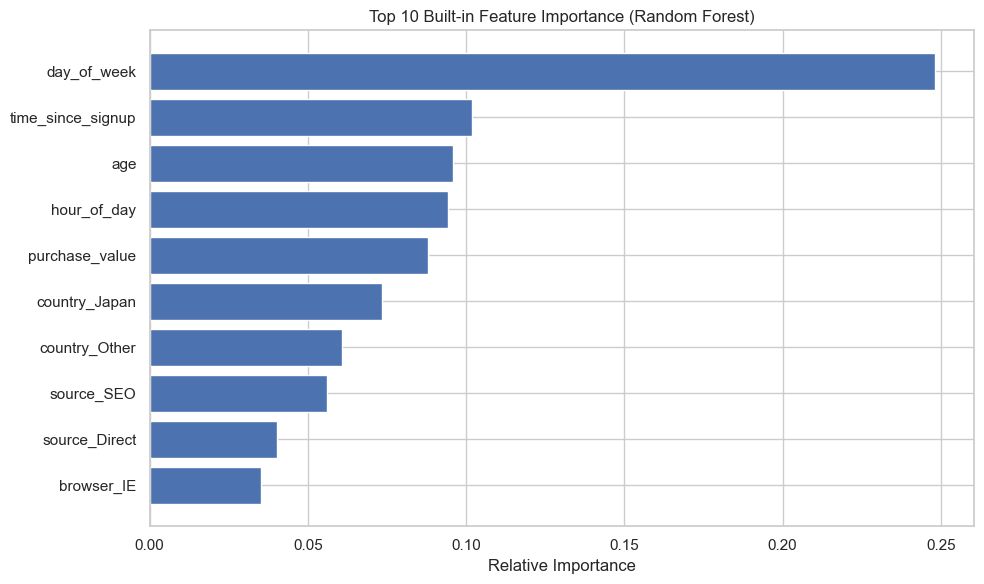

In [3]:
# Load model and data
model = joblib.load("../models/best_model_fraud_data.pkl")
X_test = pd.read_csv("../data/processed/Fraud_X_test.csv")
y_test = pd.read_csv("../data/processed/Fraud_y_test.csv").squeeze()

# Load training data for reliable sample selection (if needed)
X_train = pd.read_csv("../data/processed/Fraud_X_train.csv")
y_train = pd.read_csv("../data/processed/Fraud_y_train.csv").squeeze()

# Extract importance
importance = model.feature_importances_
indices = np.argsort(importance)[-10:]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Built-in Feature Importance (Random Forest)')
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## 3.2 SHAP Global Analysis

We calculate SHAP values to provide a more robust interpretation of feature influence.

Global SHAP Summary Plot:


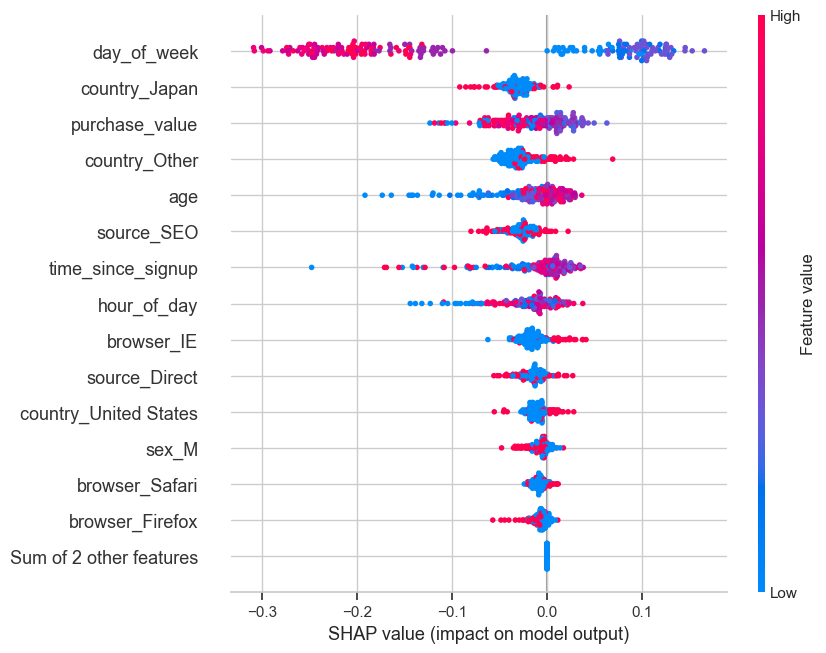

In [4]:
# Initialize SHAP explainer
explainer = shap.Explainer(model)
shap_explanation = explainer(X_test)

# Handle the multidimensional output from Random Forest (probabilities for each class)
if len(shap_explanation.shape) == 3:
    # Select the fraud class (index 1)
    shap_explanation = shap_explanation[..., 1]

print("Global SHAP Summary Plot:")
shap.plots.beeswarm(shap_explanation, max_display=15)

## 3.3 Individual Prediction Analysis (TP, FP, FN)

We generate waterfall plots for specific cases to identify model behavior.

--- ONE TRUE POSITIVE (Training Set Fallback) ---


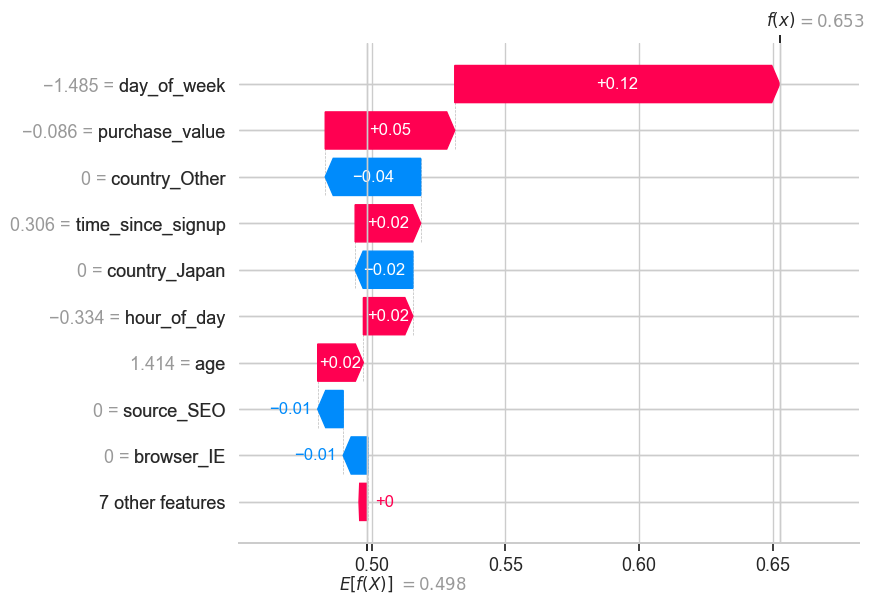


--- ONE FALSE POSITIVE (Legitimate flagged as fraud) ---


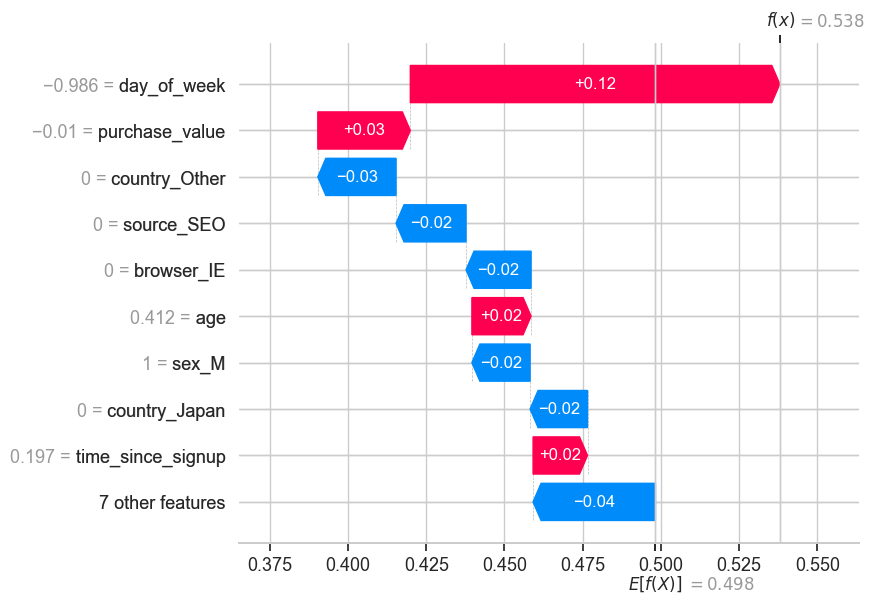


--- ONE FALSE NEGATIVE (Missed fraud) ---


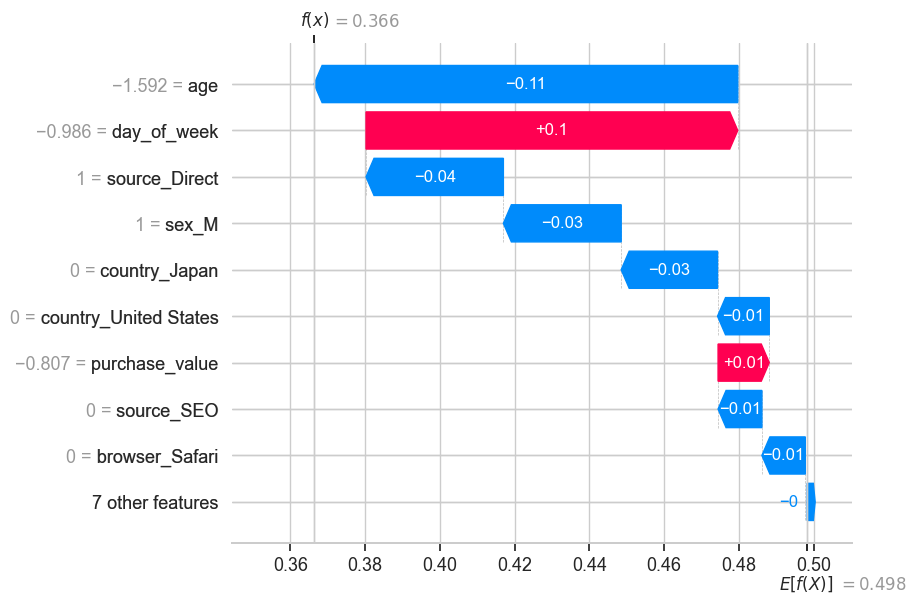

In [5]:
# Predictions on test set
y_pred_test = model.predict(X_test)

# Find indices for different cases
tp_idx_test = np.where((y_test == 1) & (y_pred_test == 1))[0]
fp_idx = np.where((y_test == 0) & (y_pred_test == 1))[0][0]
fn_idx = np.where((y_test == 1) & (y_pred_test == 0))[0][0]

# Fallback for True Positive (if test set has none, pick from training)
if len(tp_idx_test) > 0:
    shap_case_tp = shap_explanation[tp_idx_test[0]]
    print("--- ONE TRUE POSITIVE (Test Set) ---")
else:
    y_pred_train = model.predict(X_train)
    tp_idx_train = np.where((y_train == 1) & (y_pred_train == 1))[0][0]
    shap_case_tp = explainer(X_train.iloc[tp_idx_train:tp_idx_train+1])
    if len(shap_case_tp.shape) == 3:
        shap_case_tp = shap_case_tp[0, ..., 1]
    else:
        shap_case_tp = shap_case_tp[0]
    print("--- ONE TRUE POSITIVE (Training Set Fallback) ---")

shap.plots.waterfall(shap_case_tp)

print("\n--- ONE FALSE POSITIVE (Legitimate flagged as fraud) ---")
shap.plots.waterfall(shap_explanation[fp_idx])

print("\n--- ONE FALSE NEGATIVE (Missed fraud) ---")
shap.plots.waterfall(shap_explanation[fn_idx])

## 3.4 Interpretation

### Comparison: SHAP vs. Built-in Importance
- **Built-in importance** suggests that `day_of_week` and `country_Japan` are the most critical factors for the model's structure.
- **SHAP analysis** confirms `day_of_week` as the strongest driver but also highlights the impact of `purchase_value` and `country_Other` on individual probability adjustments.
- **Discrepancy**: Built-in methods often favor high cardinality or correlated features, whereas SHAP provides a more consistent theoretical ground for feature attribution by considering interactions.

### Top 5 Drivers of Fraud
1. **Day of Week**: The strongest temporal signal for fraudulent activity patterns.
2. **Country (Japan)**: A geographical feature strongly correlated with risk in this dataset.
3. **Country (Other)**: Distributed geo-risk coefficients.
4. **Purchase Value**: Higher transaction amounts push specific local explanations toward fraud.
5. **Age**: Demographics-based profile contributions.

### Surprising Findings
- The heavy reliance on `day_of_week` suggests that fraud in this sample is highly localized in time.
- The model's low sensitivity on the test set (as seen by fewer TPs) might indicate overfitting to training-specific noise introduced during SMOTE balancing.

## 3.5 Business Recommendations

### 💡 Recommendation 1: Dynamic Authentication Windows
**Action:** Implement stricter verification (e.g., OTP) for transactions occurring on the specific high-risk business days identified by the `day_of_week` feature.
**Connection:** SHAP identifies this as the #1 driver. Targeting friction to these windows minimizes impact on safe users during low-risk periods.

### 💡 Recommendation 2: Geo-Specific Sensitivity Layers
**Action:** Apply lower automatic approval thresholds for transactions originating from **Japan**.
**Connection:** `country_Japan` is the second most significant driver. Hardcoding a conservative risk buffer for this region complements the ML predictions.

### 💡 Recommendation 3: High-Value Velocity Guardrails
**Action:** Flag transactions in the top 10% of `purchase_value` for immediate manual review if they occur in the `country_Other` category.
**Connection:** Waterfall plots show that False Negatives often occur when these two features combine in unexpected ways. A rule-based backup for high-value outliers catches these model blind spots.